# Lick model

### This notebook is an initial attempt to model trains of licks when rats are choosing between two solutions (e.g. protein and carbohydrate)

In [4]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
%run helperfx

In [5]:
use_real_data = False
simulate_data = True
fit_data = False

# set parameters for simulated data
PP = 0.5
tau = 10

# set bounds for fitting data
bounds = {'PP':[0, 1, 10], 'tau':[0.5, 20, 10]}

boundbins = []
boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2]))
boundbins.append(np.arange(bounds['tau'][0], bounds['tau'][1], bounds['tau'][1]/bounds['tau'][2]))

if use_real_data and simulate_data:
    print('Over-riding simulate_data because use_real_data is selected.')
    simulate_data = False

In [6]:
# This function will be called when simulating test data and data for performing fits

def runmodel(PP, tau, nruns):
    
    # Create system with vars of interest
    System = {}
    System['PP'] = PP
    System['tau'] = tau
    System['licksinburst'] = 0
    
    # Initializes array for storing data
    output = [0.5]

    for i in range(1, nruns):
        update_func(System, output)

    # print(np.mean([x-1 for x in licks if x>0]))
    
    return output

In [7]:
def update_func(System, licks):
    pp = System['PP']
    tau = System['tau']
    x = System['licksinburst']
    
    if licks[-1] == 0.5:
            if random.random() < pp:
                licks.append(1)            
            else:
                licks.append(0)
            System['licksinburst'] = x+1
    else:
        p_cont = math.exp(-x*(1/tau))
        if random.random() < p_cont:           
            licks.append(licks[-1])
            System['licksinburst'] = x+1
        else:
            licks.append(0.5)
            System['licksinburst'] = 0          

In [8]:
test1_data_NR.keys()

NameError: name 'test1_data_NR' is not defined

In [9]:
# Code to get data to be tested - either real or simulated    
    
# in future this will allow one to select subjects and experiments by including arguments for medfile location etc    
if use_real_data:
    %run extractlicks.ipynb
    licks = test1_data_NR['IPP3.5']

if simulate_data:
    print('Simulating data with values: PP...')
    licks = runmodel(PP, tau, 1000)

Simulating data with values: PP...


In [10]:
def analyse_licks(data, bins):
    
    burstarray = []
    tmp = []
    for i, x in enumerate(data):
        if x == 0.5:
            burstarray.append(tmp)
            tmp = []
        else:
            tmp.append(x)
    
    bursts = []
    hists = []
    cumsums = []
    
    for code in [0, 1]: 
        b = [len(x) for x in burstarray[1:] if x[0]==code]
        h = np.histogram(b, bins=bins) # add binsize
        cs = np.cumsum(h[0])
        
        bursts.append(b)
        hists.append(h)
        cumsums.append(cs)
    
    return ({'licks':data, 'bursts':bursts, 'hists':hists, 'cumsums':cumsums})

In [11]:
nruns=5000

# licks = runmodel(0.5, 18, nruns)

histbins = np.arange(0,100)
lickdata = analyse_licks(licks, histbins)

In [12]:
def fit_data(lickdata, boundbins, histbins, nruns=1000):
    print('Fitting data using bounds provided.')

    nPP = bounds['PP'][2]
    ntau = bounds['tau'][2]
    
    grid = np.empty((nPP,ntau,))
    
    pp_matrix = boundbins[0]
    tau_matrix = boundbins[1]
    
    for pp_idx, pp in enumerate(pp_matrix):
        for tau_idx, tau in enumerate(tau_matrix):
            comparison_data = runmodel(pp, tau, nruns)
            licks_to_fit = analyse_licks(comparison_data, histbins)
            
            #work out loglik for hist bins using compare function and place this value in the grid
            
            diffs = []
            for bottle in [0, 1]:
                data = lickdata['hists'][bottle][0]
                comp = licks_to_fit['hists'][bottle][0]         
                diffs.append(sum([np.abs(x-y) for x,y in zip(data, comp)]))
            
            grid[pp_idx, tau_idx] = sum(diffs)
    
    grid = 1/grid
    
    tmp = np.sum(grid, axis=1)
    pp_marglik = tmp/sum(tmp)
    pp_ML = boundbins[0][np.argmax(pp_marglik)]
    pp_EV = sum(boundbins[0]*pp_marglik)
    
    tmp = np.sum(grid, axis=0)
    tau_marglik = tmp/sum(tmp)
    tau_ML = boundbins[1][np.argmax(tau_marglik)]
    tau_EV = sum(boundbins[1]*tau_marglik)
    
    fitted = {'grid':grid,
              'pp_marglik': pp_marglik, 'pp_ML':pp_ML, 'pp_EV':pp_EV,
              'tau_marglik': tau_marglik, 'tau_ML':tau_ML, 'tau_EV':tau_EV}
    
    return fitted

Fitting data using bounds provided.


Text(30.5, 0.5, 'PP')

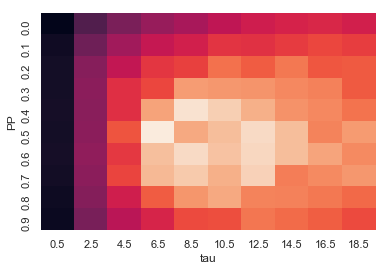

In [13]:
nruns = len(licks)

fitted = fit_data(lickdata, boundbins, histbins, nruns=nruns)

gridscores = fitted['grid']

#gridscores=new

pp_matrix = np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2])
tau_matrix = np.arange(bounds['tau'][0], bounds['tau'][1], bounds['tau'][1]/bounds['tau'][2])

pp_vals = ["{:.1f}".format(x) for x in pp_matrix]
tau_vals = ["{:.1f}".format(x) for x in tau_matrix]

import seaborn as sns; sns.set()
ax = sns.heatmap(np.log(gridscores), cbar=False, xticklabels=tau_vals, yticklabels=pp_vals)
ax.set_xlabel('tau')
ax.set_ylabel('PP')


Estimated PP= 0.4859589383343853  and estimated tau= 10.977034482136773


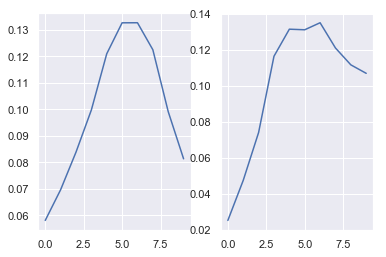

In [15]:
f, ax = plt.subplots(ncols=2)
ax[0].plot(fitted['pp_marglik'])
ax[1].plot(fitted['tau_marglik'])

print('Estimated PP=', fitted['pp_EV'], ' and estimated tau=', fitted['tau_EV'])

In [16]:
fitted['tau_EV']

10.977034482136773

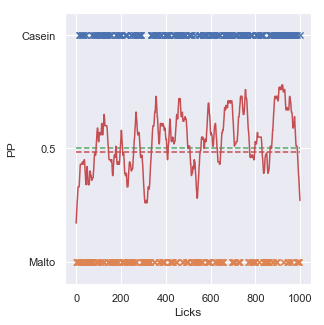

In [29]:
#f, ax = plt.subplots(figsize=(15,5), ncols=2)

def timecourseFig(lickdata, ax=ax):

    x1 = [i for i, x in enumerate(lickdata['licks']) if x == 1]
    x2 = [i for i, x in enumerate(lickdata['licks']) if x == 0]

    y1 = [1]*len(x1)
    y2 = [0]*len(x2)

    ax.plot(x1,y1, 'x')
    ax.plot(x2,y2, 'x')

    try:
        ax.plot(np.arange(0,len(licks)),[PP]*len(licks), 'g', linestyle='dashed')
    except:
        pass
    
    if fit_data:
        ax.plot(np.arange(0,len(licks)),[fitted['pp_EV']]*len(licks), 'r', linestyle='dashed')

    #ax.plot(smooth(licks, 50), 'b')
    ax.plot(smooth2(licks, 50), 'r')

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Licks')
    ax.set_ylabel('PP')
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Malto', '0.5', 'Casein'])

f = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3)
ax1 = f.add_subplot(gs[0, 0])

timecourseFig(lickdata, ax=ax1)


    
# bins = np.arange(1,20)
# ax[1].plot(lickdata['cumsums'][0])
# ax[1].plot(lickdata['cumsums'][1])
# ax[1].set_xticks([0, 5, 10, 15])
# ax[1].set_xscale('log')
# #ax[1].set_xticks([0, 5, 10, 15])

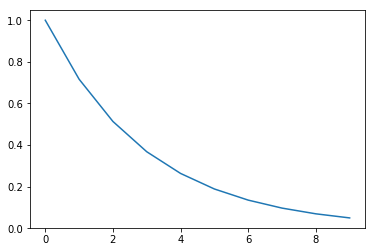

In [9]:
f, ax = plt.subplots()

lick_array = np.arange(0,10)
k=3
next_lick_p = [math.exp(-x*(1/k)) for x in lick_array]

ax.plot(lick_array, next_lick_p)



In [11]:
%who_ls dict

['lickdict', 'test1_data_NR', 'test1_data_PR']